In [1]:
%matplotlib inline
%pprint on

Pretty printing has been turned OFF


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import utils
import os
from PIL import Image
import json
import torch
import json
from gensim.models.keyedvectors import KeyedVectors
from types import SimpleNamespace
from networks import TextEncoder, ImageEncoder, DiscourseClassifier
from datasets import CoherenceDataset, val_transform
from torch.utils.data import DataLoader
from tqdm import tqdm
import re
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
import pandas as pd

In [3]:
def load_model(path, with_attention=2):
    text_encoder = TextEncoder(
        emb_dim=args.word2vec_dim,
        hid_dim=args.rnn_hid_dim,
        z_dim=args.feature_dim,
        max_len = args.max_len,
        word2vec_file=f'models/word2vec_{args.data_source}.bin',
        with_attention=with_attention).to(device)
    image_encoder = ImageEncoder(
        z_dim=args.feature_dim).to(device)
    discourse_class = DiscourseClassifier(
        len(relations), args.feature_dim).to(device)

    ckpt = torch.load(path)
    text_encoder.load_state_dict(ckpt['text_encoder'])
    image_encoder.load_state_dict(ckpt['image_encoder'])
    discourse_class.load_state_dict(ckpt['discourse_class'])
    return text_encoder, image_encoder, discourse_class

In [4]:
def generate_output(test_loader, text_encoder, image_encoder, discourse_class, valid_questions):
    txt_feats = []
    img_feats = []
    probs = []
    labels = []
    attns = []
    for batch in tqdm(test_loader):
        for i in range(len(batch)):
            batch[i] = batch[i].to(device)
        txt, txt_len, img, target = batch
        with torch.no_grad():
            txt_feat, attn = text_encoder(txt.long(), txt_len)
            img_feat = image_encoder(img)
            prob = torch.sigmoid(discourse_class(txt_feat, img_feat))[:,valid_questions]
            txt_feats.append(txt_feat.detach().cpu())
            img_feats.append(img_feat.detach().cpu())
            probs.append(prob.detach().cpu())
            if text_encoder.with_attention:
                attns.append(attn.detach().cpu())
            labels.append(target[:,valid_questions].detach().cpu())

    txt_feats = torch.cat(txt_feats, dim=0).numpy()
    img_feats = torch.cat(img_feats, dim=0).numpy()
    probs = torch.cat(probs, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    if text_encoder.with_attention:
        attns = torch.cat(attns, dim=0).numpy()
    return probs, labels, attns, txt_feats, img_feats

In [5]:
def rank(rcps, imgs, retrieved_type='image', retrieved_range=1000, n_repeat=30):
    N = retrieved_range
    data_size = imgs.shape[0]
    idxs = range(N)
    glob_rank = []
    glob_recall = {1: 0.0, 5: 0.0, 10: 0.0}
    # average over 20 sets
    for i in range(n_repeat):
        ids_sub = np.random.choice(data_size, N, replace=False)
        imgs_sub = imgs[ids_sub, :]
        rcps_sub = rcps[ids_sub, :]
        imgs_sub = imgs_sub / np.linalg.norm(imgs_sub, axis=1)[:, None]
        rcps_sub = rcps_sub / np.linalg.norm(rcps_sub, axis=1)[:, None]
        if retrieved_type == 'recipe':
            sims = np.dot(imgs_sub, rcps_sub.T)  # [N, N]
        else:
            sims = np.dot(rcps_sub, imgs_sub.T)
        med_rank = []
        recall = {1: 0.0, 5: 0.0, 10: 0.0}
        # loop through the N similarities for images
        for ii in idxs:
            # get a column of similarities for image ii
            sim = sims[ii, :]
            # sort indices in descending order
            sorting = np.argsort(sim)[::-1].tolist()
            # find where the index of the pair sample ended up in the sorting
            pos = sorting.index(ii)
            if (pos + 1) == 1:
                recall[1] += 1
            if (pos + 1) <= 5:
                recall[5] += 1
            if (pos + 1) <= 10:
                recall[10] += 1
            # store the position
            med_rank.append(pos+1)

        for i in recall.keys():
            recall[i] = recall[i]/N
        med = np.median(med_rank)
        for i in recall.keys():
            glob_recall[i] += recall[i]
        glob_rank.append(med)

    for i in glob_recall.keys():
        glob_recall[i] = glob_recall[i]/10
    return np.asarray(glob_rank), glob_recall

# Boxplot the performances of different models

In [6]:
class Config:
    def __init__(self, name, path, questions, with_attention):
        self.name = name
        self.path = path
        self.questions = questions
        self.with_attention = with_attention
        self.medRs = None
        self.recalls = None

## Clue

In [7]:
device = 'cuda'
args = {
    'data_source': 'clue',
    'img_dir': '../data/conceptual/images/',
    'word2vec_dim': 300,
    'rnn_hid_dim': 300,
    'feature_dim': 1024,
    'max_len': 40,
    'dataset_q': 0,
    'with_attention': 2,
    'batch_size': 64,
    'workers': 4
}
args = SimpleNamespace(**args)
relations = relations = ['Visible', 'Subjective', 'Action', 'Story', 'Meta', 'Irrelevant']

In [8]:
test_set = CoherenceDataset(
            part='test',
            datasource=args.data_source,
            word2vec_file=f'models/word2vec_{args.data_source}.bin',
            max_len=args.max_len,
            dataset_q=args.dataset_q,  # experimental things, ignore it for now
            transform=val_transform)

test_loader = DataLoader(
            test_set, batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True,
            drop_last=False)

print('test data:', len(test_set), len(test_loader))

vocab size = 5612
test data: 1512 24


In [9]:
configs = []
# Base
path = 'runs/samples6047_retrieval=1.00_classification=0.00_reweight=1000.00_weightDecay=0.0_withAttention=0_question=0,1,2,3,4,5_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([0,1,2,3,4,5], dtype=torch.long)
with_attention = 0
configs.append(Config('Base', path, valid_questions, with_attention))

# CMCA
path = 'runs/samples6047_retrieval=1.00_classification=0.00_reweight=1000.00_weightDecay=0.0_withAttention=2_question=0,1,2,3,4,5_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([0,1,2,3,4,5], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCA', path, valid_questions, with_attention))

# CMCM-NoAttn
path = 'runs/samples6047_retrieval=1.00_classification=0.00_reweight=1000.00_weightDecay=0.0_withAttention=0_question=0,1,2,3,4,5_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([0,1,2,3,4,5], dtype=torch.long)
with_attention = 0
configs.append(Config('CMCM-NoAttn', path, valid_questions, with_attention))

# CMCM
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=0,1,2,3,4,5_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([0,1,2,3,4,5], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM', path, valid_questions, with_attention))

# Visible
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=0_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([0], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM_{Visible}', path, valid_questions, with_attention))

# Subjective
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=1_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([1], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM_{Subjective}', path, valid_questions, with_attention))

# Action
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=2_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([2], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM_{Action}', path, valid_questions, with_attention))

# Story
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=3_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([3], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM_{Story}', path, valid_questions, with_attention))

# Meta
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=4_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([4], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM_{Meta}', path, valid_questions, with_attention))

# Irrelavant
path = 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=5_maxLen=40/e14.ckpt'
valid_questions = torch.tensor([5], dtype=torch.long)
with_attention = 2
configs.append(Config('CMCM_{Irrelavant}', path, valid_questions, with_attention))

len(configs)

10

In [10]:
for config in configs:
    print(config)
    txt_encoder, img_encoder, classifier = load_model(config.path, with_attention=config.with_attention)
    probs_test, labels_test, attns_test, txt_test, img_test = generate_output(test_loader, txt_encoder, img_encoder, classifier, config.questions)
    probs_test.shape
    retrieved_range = min(txt_test.shape[0], 500)
    print('retrieved_range =', retrieved_range)
    medRs, recalls = rank(
        txt_test, 
        img_test, 
        retrieved_type='image', 
        retrieved_range=retrieved_range,
        n_repeat=50)
    config.medRs = medRs
    config.recalls = recalls

100%|██████████| 24/24 [00:49<00:00,  2.04s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:50<00:00,  2.11s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:48<00:00,  2.03s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:48<00:00,  2.02s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:50<00:00,  2.10s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:49<00:00,  2.07s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:50<00:00,  2.09s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:51<00:00,  2.16s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:48<00:00,  2.02s/it]


retrieved_range = 500


100%|██████████| 24/24 [00:49<00:00,  2.05s/it]


retrieved_range = 500



 Base
24.32 2.721690651047617
1 0.5783999999999999
5 1.3601999999999994
10 1.8210000000000002

 CMCA
21.19 2.0539961051569695
1 0.6521999999999999
5 1.4821999999999997
10 1.9376000000000002

 CMCM-NoAttn
24.67 2.7433738352619756
1 0.5808
5 1.389
10 1.828

 CMCM
21.04 2.1280037593951757
1 0.6472000000000001
5 1.4409999999999996
10 1.9308000000000003

 CMCM_{Visible}
22.18 3.2011872797448135
1 0.6360000000000001
5 1.4991999999999996
10 1.9889999999999997

 CMCM_{Subjective}
27.96 3.1604430069216565
1 0.5299999999999999
5 1.299
10 1.7575999999999994

 CMCM_{Action}
22.49 2.7613221470882388
1 0.6411999999999999
5 1.4710000000000003
10 1.9116000000000004

 CMCM_{Story}
20.66 2.093895890439637
1 0.6234
5 1.4506
10 1.9300000000000002

 CMCM_{Meta}
21.37 2.6245190035509363
1 0.6454
5 1.4602000000000004
10 1.9242000000000004

 CMCM_{Irrelavant}
22.2 2.6362852652928135
1 0.6391999999999998
5 1.4703999999999993
10 1.9314000000000004


<Figure size 1440x1152 with 0 Axes>

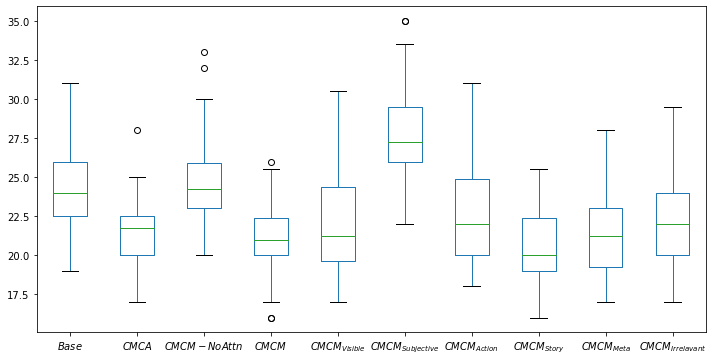

In [11]:
df = pd.DataFrame()
for config in configs:
    df[config.name] = config.medRs
    print(f'\n {config.name}')
    print(config.medRs.mean(), config.medRs.std())
    for r,v in config.recalls.items():
        print(r,v)

plt.figure(figsize=(20,16))
df.plot.box(subplots=False, figsize=(12,6))
ticks = range(1, len(configs)+1)
labels = [r'${}$'.format(x.name) for x in configs]
plt.xticks(ticks, labels)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "10"